# ScoreCAM on B-scan

cite:
- https://github.com/haofanwang/Score-CAM/blob/master/README.md
- https://github.com/yiskw713/ScoreCAM/blob/master/README.md

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torchvision import models
from PIL import Image
import os
import math

In [21]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


## ScoreCAM Implementation

In [ ]:
# Load the trained model from .pth file
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits

# Function to load the trained model
def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    # print(model)
    return model

# Load model
model_path = "best_VGG_model_1.pth"  
model = load_model(model_path,device)

# Select the target convolutional layer (last conv layer in VGG16 features block)
target_layer = model.vgg16.features[28]  # Last conv layer before FC layers

/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_64942/1385931762.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https

### Preprocess & Transform

In [ ]:
# Preprocessing pipeline
def preprocess_image(image_path, directory):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(os.path.join(directory, image_path)).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

def denormalize(tensor):
    """Reverses the normalisation on a tensor.

    Performs a reverse operation on a tensor, so the pixel value range is
    between 0 and 1. Useful for when plotting a tensor into an image.

    Normalisation: (image - mean) / std
    Denormalisation: image * std + mean

    Args:
        tensor (torch.Tensor, dtype=torch.float32): Normalized image tensor

    Shape:
        Input: :math:`(N, C, H, W)`
        Output: :math:`(N, C, H, W)` (same shape as input)

    Return:
        torch.Tensor (torch.float32): Demornalised image tensor with pixel
            values between [0, 1]

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    denormalized = tensor.clone()

    for channel, mean, std in zip(denormalized[0], means, stds):
        channel.mul_(std).add_(mean)

    return denormalized


def standardize_and_clip(tensor, min_value=0.0, max_value=1.0):
    """Standardizes and clips input tensor.

    Standardize the input tensor (mean = 0.0, std = 1.0), ensures std is 0.1
    and clips it to values between min/max (default: 0.0/1.0).

    Args:
        tensor (torch.Tensor):
        min_value (float, optional, default=0.0)
        max_value (float, optional, default=1.0)

    Shape:
        Input: :math:`(C, H, W)`
        Output: Same as the input

    Return:
        torch.Tensor (torch.float32): Normalised tensor with values between
            [min_value, max_value]

    """

    tensor = tensor.detach().cpu()

    mean = tensor.mean()
    std = tensor.std()
    if std == 0:
        std += 1e-7

    standardized = tensor.sub(mean).div(std).mul(0.1)
    clipped = standardized.add(0.5).clamp(min_value, max_value)

    return clipped


def format_for_plotting(tensor):
    """Formats the shape of tensor for plotting.

    Tensors typically have a shape of :math:`(N, C, H, W)` or :math:`(C, H, W)`
    which is not suitable for plotting as images. This function formats an
    input tensor :math:`(H, W, C)` for RGB and :math:`(H, W)` for mono-channel
    data.

    Args:
        tensor (torch.Tensor, torch.float32): Image tensor

    Shape:
        Input: :math:`(N, C, H, W)` or :math:`(C, H, W)`
        Output: :math:`(H, W, C)` or :math:`(H, W)`, respectively

    Return:
        torch.Tensor (torch.float32): Formatted image tensor (detached)

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()
        
def basic_visualize(input_, gradients, save_path=None, weight=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """
    input_ = format_for_plotting(denormalize(input_))
    gradients = format_for_plotting(standardize_and_clip(gradients))

    # Create figure with original image size
    subplots = [
        ('Original', [(input_, None, None)]),
        ('ScoreCAM', [(input_, None, None), (gradients, cmap, alpha)])
    ]

    num_subplots = len(subplots)
    fig = plt.figure(figsize=(10, 15))  # Adjust size based on image dimensions

    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_title(title)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            ax.imshow(image, cmap=cmap, alpha=alpha)
            
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved to {save_path}")

    plt.show()

### ScoreCAM

In [69]:
class SaveValues():
    def __init__(self, m):
        # register a hook to save values of activations and gradients
        self.activations = None
        self.gradients = None
        self.forward_hook = m.register_forward_hook(self.hook_fn_act)
        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)

    def hook_fn_act(self, module, input, output):
        self.activations = output

    def hook_fn_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove(self):
        self.forward_hook.remove()
        self.backward_hook.remove()
        
class CAM(object):
    """ Class Activation Mapping """

    def __init__(self, model, target_layer):
        """
        Args:
            model: a base model to get CAM which have global pooling and fully connected layer.
            target_layer: conv_layer before Global Average Pooling
        """

        self.model = model
        self.target_layer = target_layer

        # save values of activations and gradients in target_layer
        self.values = SaveValues(self.target_layer)

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # object classification
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if idx is None:
            prob, idx = torch.max(prob, dim=1)
            idx = idx.item()
            prob = prob.item()
            print("predicted class ids {}\t probability {}".format(idx, prob))

        # cam can be calculated from the weights of linear layer and activations
        weight_fc = list(
            self.model._modules.get('fc').parameters())[0].to('cpu').data

        cam = self.getCAM(self.values, weight_fc, idx)

        return cam, idx

    def __call__(self, x):
        return self.forward(x)

    def getCAM(self, values, weight_fc, idx):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        weight_fc: the weight of fully connected layer.  shape => (num_classes, C)
        idx: predicted class id
        cam: class activation map.  shape => (1, num_classes, H, W)
        '''

        cam = F.conv2d(values.activations, weight=weight_fc[:, :, None, None])
        _, _, h, w = cam.shape

        # class activation mapping only for the predicted class
        # cam is normalized with min-max.
        cam = cam[:, idx, :, :]
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        cam = cam.view(1, 1, h, w)

        return cam.data
    
class ScoreCAM(CAM):
    """ Score CAM """

    def __init__(self, model, target_layer, n_batch=32):
        super().__init__(model, target_layer)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
        """
        self.n_batch = n_batch

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        with torch.no_grad():
            _, _, H, W = x.shape
            device = x.device

            self.model.zero_grad()
            score = self.model(x)
            prob = F.softmax(score, dim=1)

            if idx is None:
                p, idx = torch.max(prob, dim=1)
                idx = idx.item()
                # print("predicted class ids {}\t probability {}".format(idx, p))

            # # calculate the derivate of probabilities, not that of scores
            # prob[0, idx].backward(retain_graph=True)

            self.activations = self.values.activations.to('cpu').clone()
            # put activation maps through relu activation
            # because the values are not normalized with eq.(1) without relu.
            self.activations = F.relu(self.activations)
            self.activations = F.interpolate(
                self.activations, (H, W), mode='bilinear')
            _, C, _, _ = self.activations.shape

            # normalization
            act_min, _ = self.activations.view(1, C, -1).min(dim=2)
            act_min = act_min.view(1, C, 1, 1)
            act_max, _ = self.activations.view(1, C, -1).max(dim=2)
            act_max = act_max.view(1, C, 1, 1)
            denominator = torch.where(
                (act_max - act_min) != 0., act_max - act_min, torch.tensor(1.)
            )

            self.activations = self.activations / denominator

            # generate masked images and calculate class probabilities
            probs = []
            for i in range(0, C, self.n_batch):
                mask = self.activations[:, i:i+self.n_batch].transpose(0, 1)
                mask = mask.to(device)
                masked_x = x * mask
                score = self.model(masked_x)
                probs.append(F.softmax(score, dim=1)[:, idx].to('cpu').data)

            probs = torch.stack(probs)
            weights = probs.view(1, C, 1, 1)

            # shape = > (1, 1, H, W)
            cam = (weights * self.activations).sum(1, keepdim=True)
            cam = F.relu(cam)
            cam -= torch.min(cam)
            cam /= torch.max(cam)

        return cam.data, idx

### Run pipeline

**One image testing**

In [151]:
directory = "labeled_dataset/fovea_yes/"
image_path = "2002000051_20240716_75500_OS_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg"

image_tensor = preprocess_image(image_path, directory).to(device)
wrapped_model = ScoreCAM(model, target_layer)
cam, idx = wrapped_model(image_tensor)
# visualize original image and cam
basic_visualize(image_tensor.cpu(), cam.cpu())

RuntimeError: Adaptive pool MPS: input sizes must be divisible by output sizes. Non-divisible input sizes are not implemented on MPS device yet. For now, you can manually transfer tensor to cpu in this case. Please refer to [this issue](https://github.com/pytorch/pytorch/issues/96056)

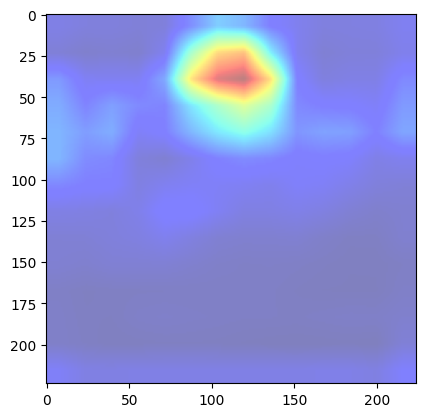

In [138]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

**Volume Matrix testing**

In [ ]:
def show_result(volume_path, read_txt_path, max_images=20):
    # Read the saved text file
    with open(read_txt_path, "r") as f:
        class_1_images = [line.rsplit(maxsplit=1) for line in f.readlines()]
    print(f"Number of images in the text file: {len(class_1_images)}")

    # Function to extract squence number from img_name
    def extract_serial_number(img_name):
        return img_name.split("_")[-1].split(".")[0]  # Extract last part before ".jpg"

    # Convert labels to integers correctly and filter images where label == 1
    class_1 = [(img_name, extract_serial_number(img_name)) for img_name, label in class_1_images if int(label.strip("[]")) == 1]

    num_images_to_show = len(class_1)
    images_per_row = 5
    num_rows = math.ceil(num_images_to_show / images_per_row)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 3 * num_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    for idx, (img_name, serial_number) in enumerate(class_1[:num_images_to_show]):
        # Load image
        image_tensor = preprocess_image(img_name, volume_path).to(device)

        # Generate Score-CAM
        wrapped_model = ScoreCAM(model, target_layer)
        cam, idx = wrapped_model(image_tensor)
        input_ = np.array(format_for_plotting(denormalize(image_tensor.cpu())))
        gradients = format_for_plotting(standardize_and_clip(cam.cpu()))   
        score_cam = np.dstack[input_, (gradients, 'viridis', 0.7)]
        
        # TODO Save images to a file
        save_path = os.path.join(volume_path, f"{serial_number}.png")

        axes[idx].imshow(score_cam)
        axes[idx].axis("off")
        axes[idx].set_title(f"SN: {serial_number}")  # Display sequence number as title

    # Hide unused subplots
    for idx in range(num_images_to_show, len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

Total images:  77
Image: 2002000255_20240419_102800_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_072.jpg, Label: 1
Saved to score_cam/healthy_no/cam_2002000255_20240419_102800_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_072.jpg


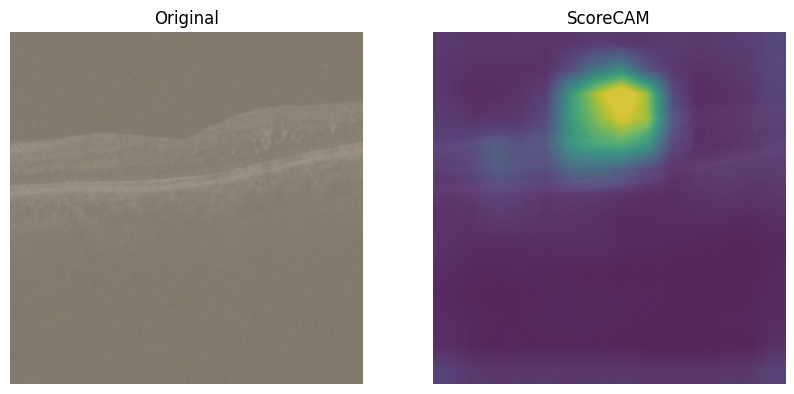

Image: 3003000001_20210525_101500_L_Carl Zeiss Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg, Label: 1
Saved to score_cam/healthy_no/cam_3003000001_20210525_101500_L_Carl Zeiss Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg


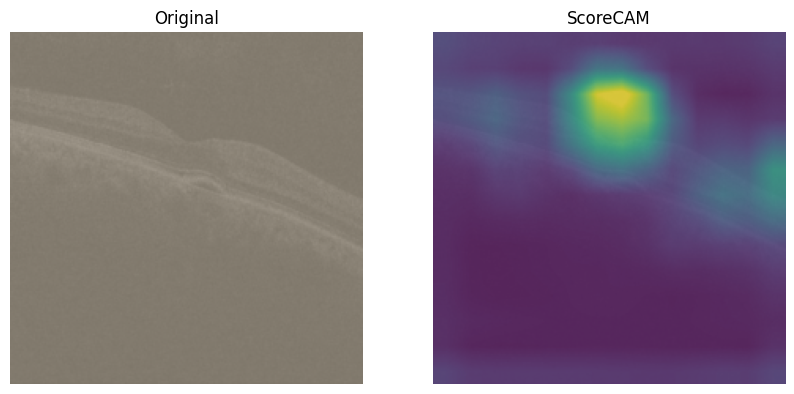

Image: 2002000250_20240718_80800_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg, Label: 1
Saved to score_cam/healthy_no/cam_2002000250_20240718_80800_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg


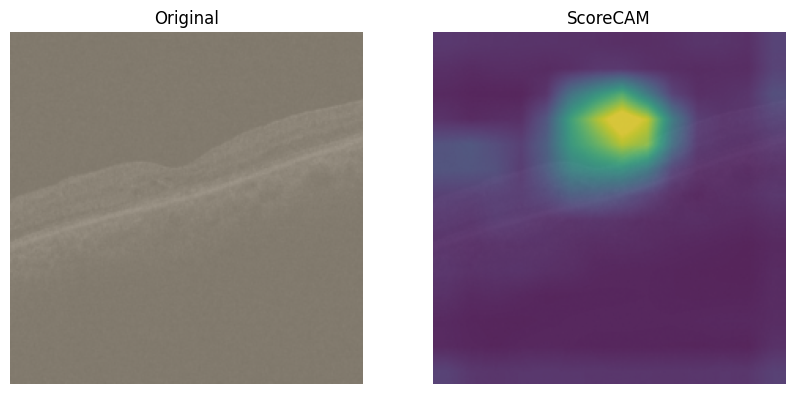

Image: RID_1001001479_20180917_161555_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg, Label: 1
Saved to score_cam/healthy_no/cam_RID_1001001479_20180917_161555_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg


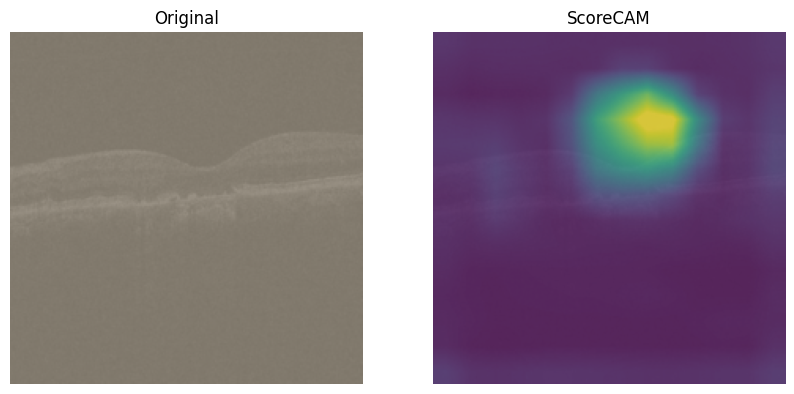

Image: 2002000198_20221101_90000_OS_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_056.jpg, Label: 1
Saved to score_cam/healthy_no/cam_2002000198_20221101_90000_OS_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_056.jpg


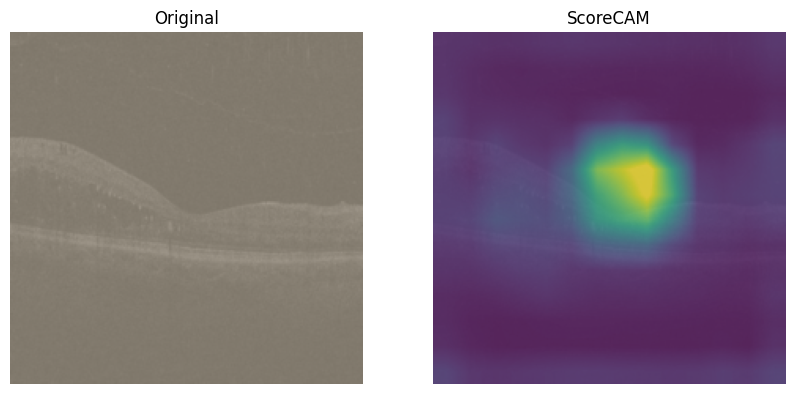

In [ ]:
# Function to read the classification results file and filter label 1
def read_classification_results(file_path):
    image_labels = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().rsplit(' ', 1)
            if len(parts) == 2:
                filename, label = parts[0], int(parts[1][1])  # Extract filename and label
                if label == 1:
                    image_labels.append((filename, label))
    return image_labels

# healthy_no
directory = "labeled_dataset/healthy_no"
results_file = "class_1_predictions_healthy_no.txt"  
image_data = read_classification_results(results_file)
print("Total images: ",len(image_data))

# Show results for the first 5 images
for img_name, label in image_data[:5]:
    print(f"Image: {img_name}, Label: {label}")
    image_tensor = preprocess_image(img_name, directory).to(device)
    wrapped_model = ScoreCAM(model, target_layer)
    cam, idx = wrapped_model(image_tensor)
    basic_visualize(image_tensor.cpu(), cam.cpu(), 
                     save_path=os.path.join(f"score_cam/healthy_no", f"cam_{img_name}"))

Total images:  30
Image: RID_1001001456_20180409_164324_R_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0073.jpg, Label: 1
Saved to score_cam/healthy_yes/cam_RID_1001001456_20180409_164324_R_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0073.jpg


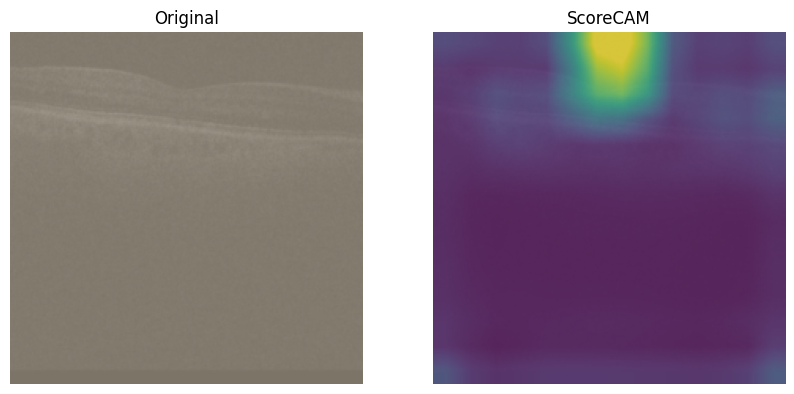

Image: RID_1001001766_20191021_162241_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0057.jpg, Label: 1
Saved to score_cam/healthy_yes/cam_RID_1001001766_20191021_162241_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0057.jpg


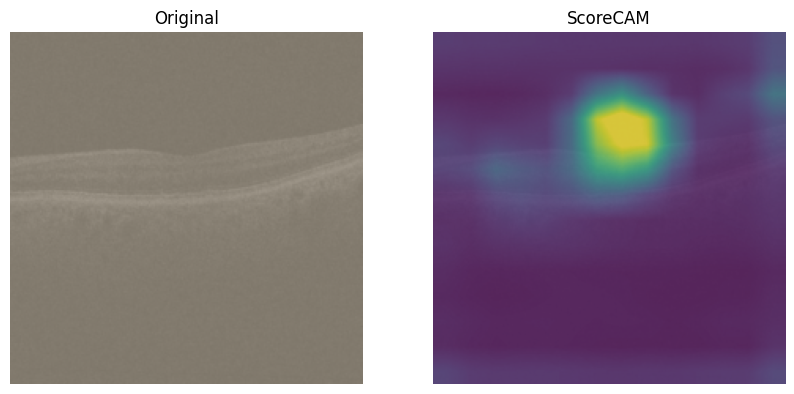

Image: RID_1001001803_20180827_152837_R_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0073.jpg, Label: 1
Saved to score_cam/healthy_yes/cam_RID_1001001803_20180827_152837_R_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0073.jpg


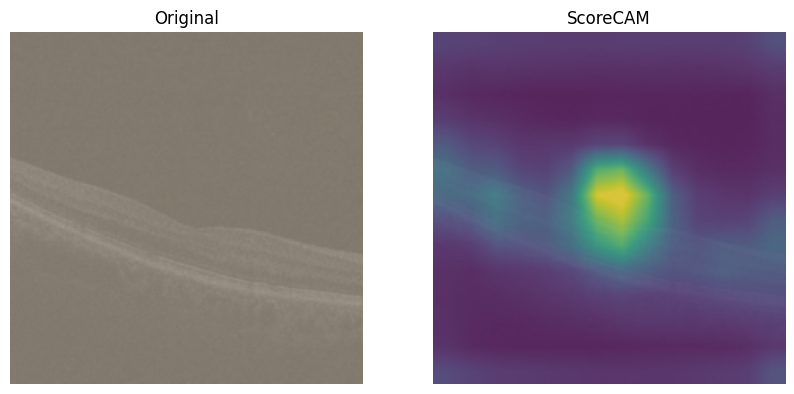

Image: 2002000093_20240529_93900_OS_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg, Label: 1
Saved to score_cam/healthy_yes/cam_2002000093_20240529_93900_OS_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg


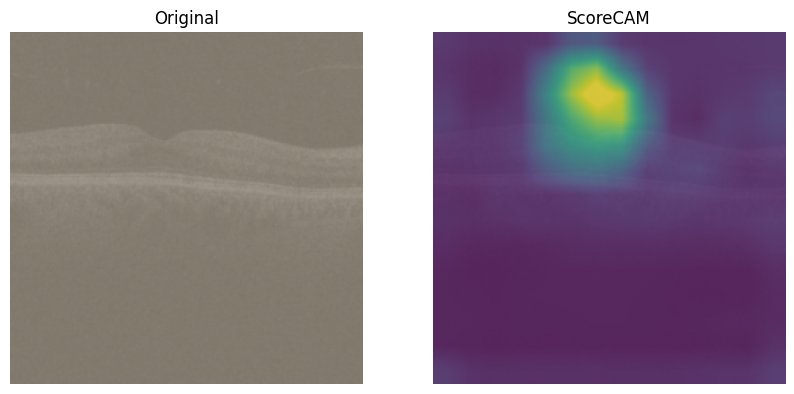

Image: RID_1001001769_20191022_163949_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg, Label: 1
Saved to score_cam/healthy_yes/cam_RID_1001001769_20191022_163949_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg


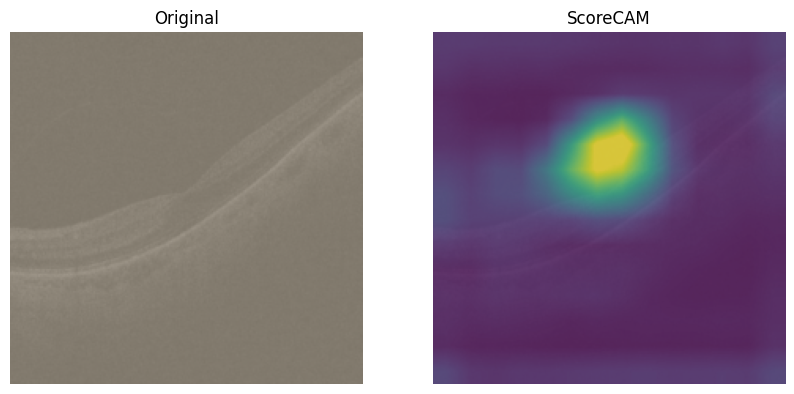

In [ ]:
# healthy_yes
directory = "labeled_dataset/healthy_yes"
results_file = "class_1_predictions_healthy_yes.txt"  
image_data = read_classification_results(results_file)
print("Total images: ",len(image_data))

# Show results for the first 20 images
for img_name, label in image_data[:5]:
    print(f"Image: {img_name}, Label: {label}")
    image_tensor = preprocess_image(img_name, directory).to(device)
    wrapped_model = ScoreCAM(model, target_layer)
    cam, idx = wrapped_model(image_tensor)
    basic_visualize(image_tensor.cpu(), cam.cpu(), 
                     save_path=os.path.join(f"score_cam/healthy_yes", f"cam_{img_name}"))

Total images:  5
Image: 2002000015_20240305_91500_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg, Label: 1
Saved to score_cam/fovea_yes/cam_2002000015_20240305_91500_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg


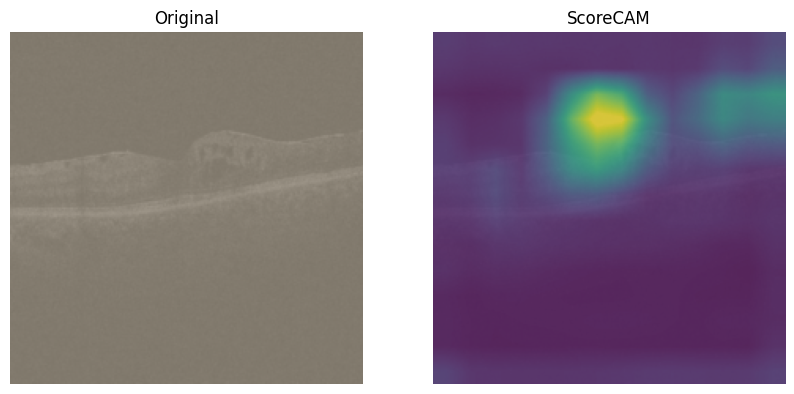

Image: RID_1001001619_20190529_165051_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg, Label: 1
Saved to score_cam/fovea_yes/cam_RID_1001001619_20190529_165051_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg


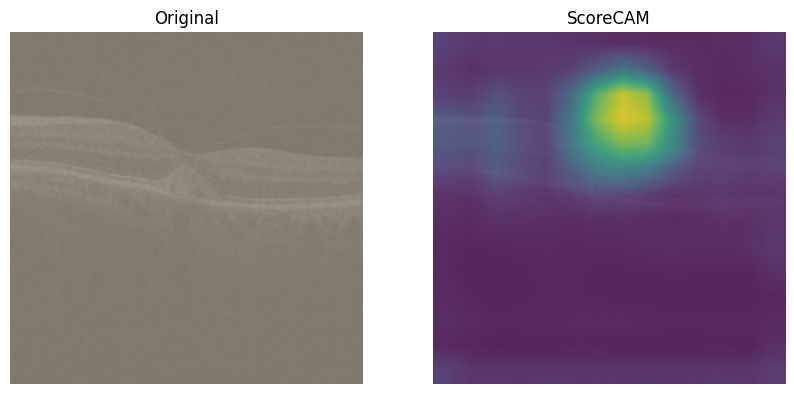

Image: RID_1001001484_20191216_161834_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg, Label: 1
Saved to score_cam/fovea_yes/cam_RID_1001001484_20191216_161834_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg


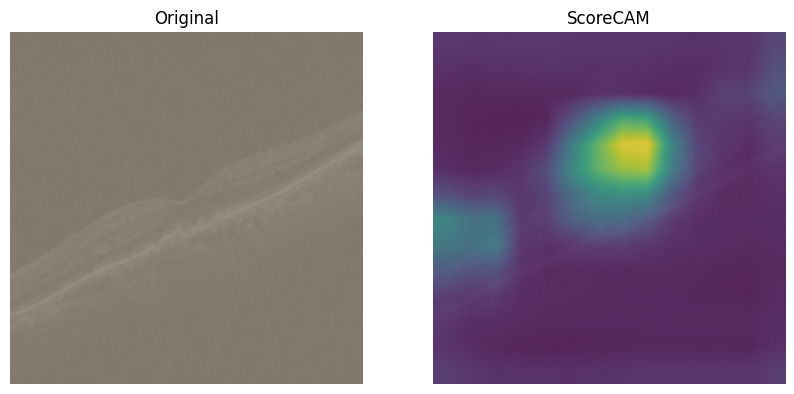

Image: RID_1001000333_20191205_154613_R_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0057.jpg, Label: 1
Saved to score_cam/fovea_yes/cam_RID_1001000333_20191205_154613_R_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0057.jpg


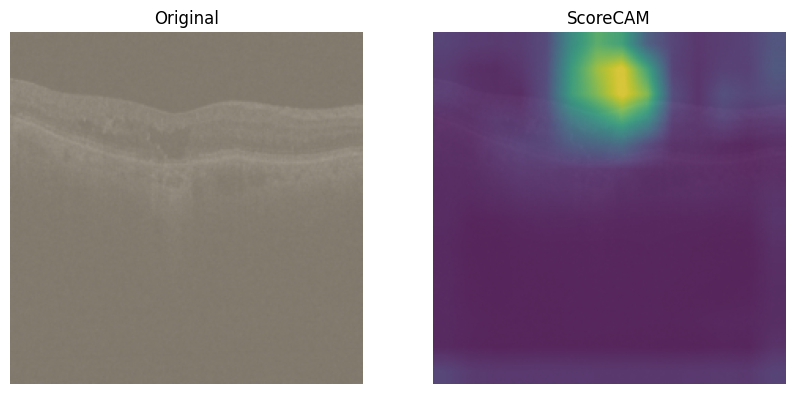

Image: 3003000002_20140204_161923_R_Carl Zeiss Meditec_4000_512x1024x128_ORG_IMG_JPG_064.jpg, Label: 1
Saved to score_cam/fovea_yes/cam_3003000002_20140204_161923_R_Carl Zeiss Meditec_4000_512x1024x128_ORG_IMG_JPG_064.jpg


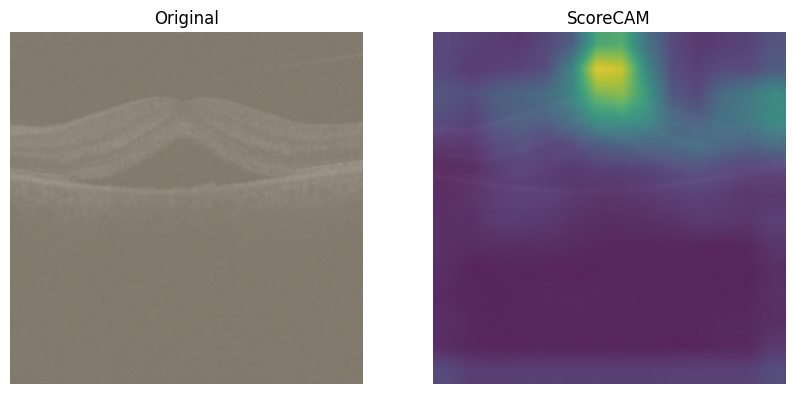

In [147]:
# fovea_yes
directory = "labeled_dataset/fovea_yes"  
image_data = ["2002000015_20240305_91500_OD_Carl_Zeiss_Meditec_5000_512x1024x128_ORG_IMG_JPG_064.jpg",
              "RID_1001001619_20190529_165051_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg",
              "RID_1001001484_20191216_161834_L_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0065.jpg",
              "RID_1001000333_20191205_154613_R_CIRRUS_HD-OCT_5000_512x1024x128_ORG_IMG_JPG_0057.jpg",
              "3003000002_20140204_161923_R_Carl Zeiss Meditec_4000_512x1024x128_ORG_IMG_JPG_064.jpg"]
print("Total images: ",len(image_data))

# Show results for the first 20 images
for img_name in image_data:
    print(f"Image: {img_name}, Label: {label}")
    image_tensor = preprocess_image(img_name, directory).to(device)
    wrapped_model = ScoreCAM(model, target_layer)
    cam, idx = wrapped_model(image_tensor)
    basic_visualize(image_tensor.cpu(), cam.cpu(), 
                     save_path=os.path.join(f"score_cam/fovea_yes", f"cam_{img_name}"))

Total images:  19
Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0057.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0057.jpg


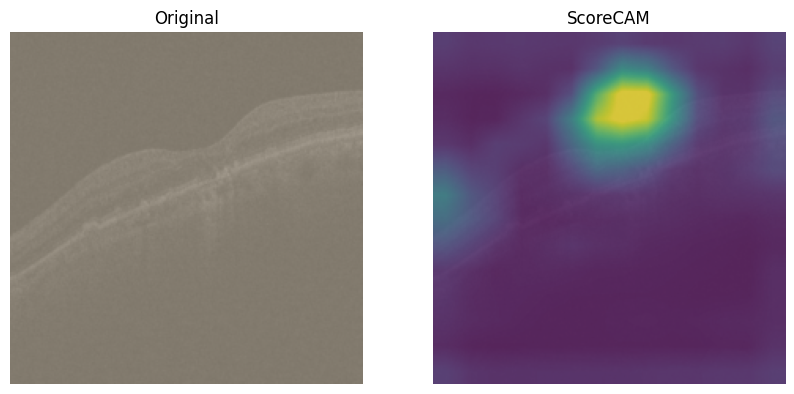

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0069.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0069.jpg


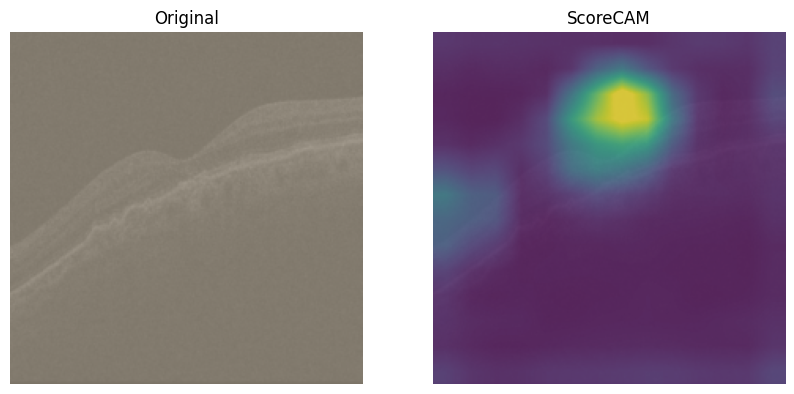

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0068.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0068.jpg


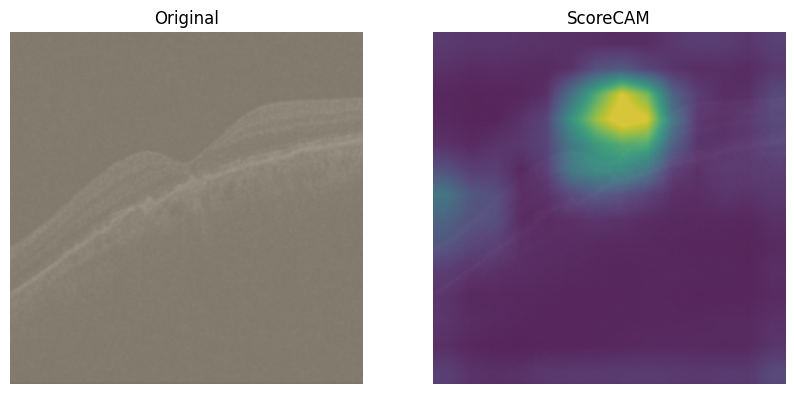

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0063.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0063.jpg


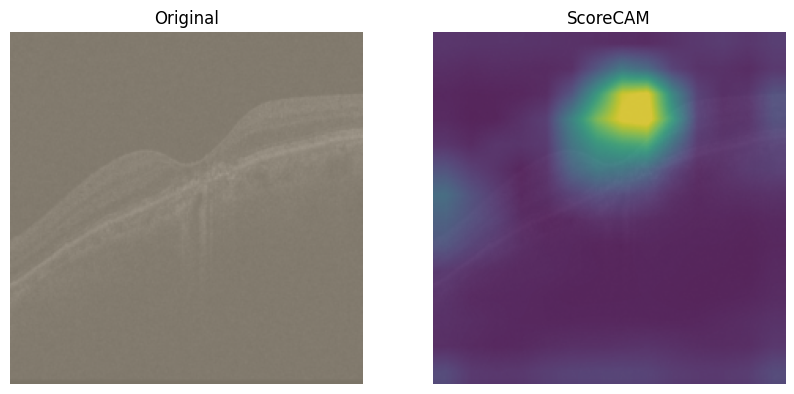

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0062.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0062.jpg


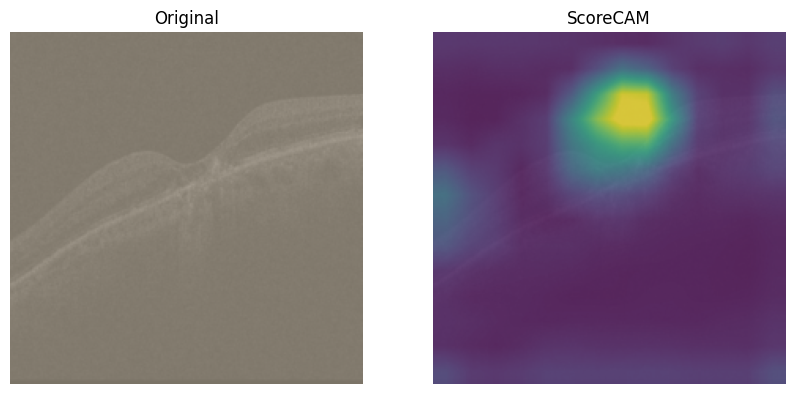

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0074.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0074.jpg


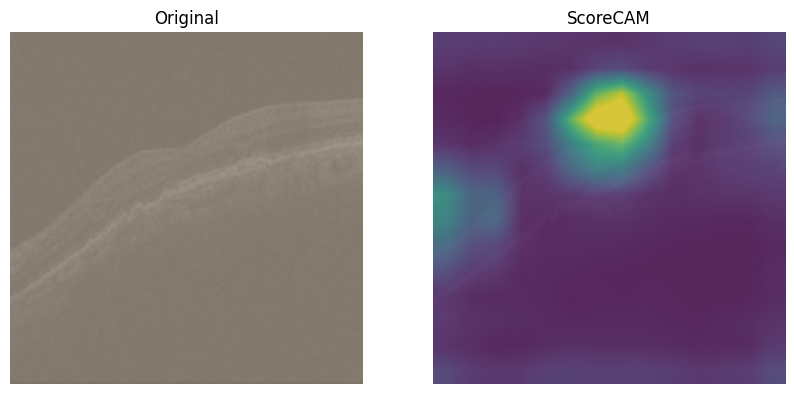

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0060.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0060.jpg


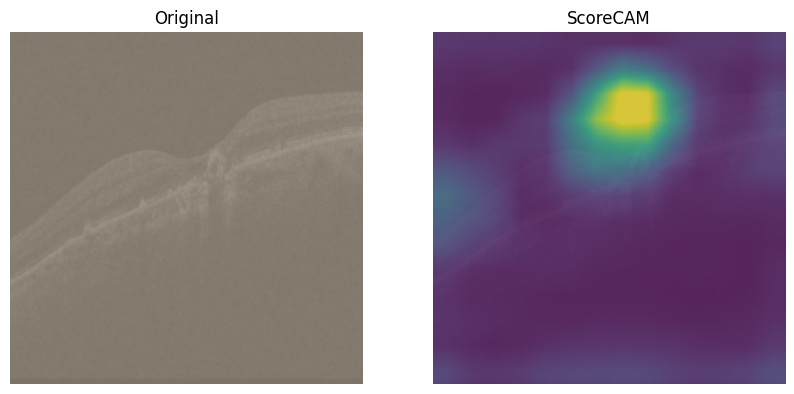

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0061.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0061.jpg


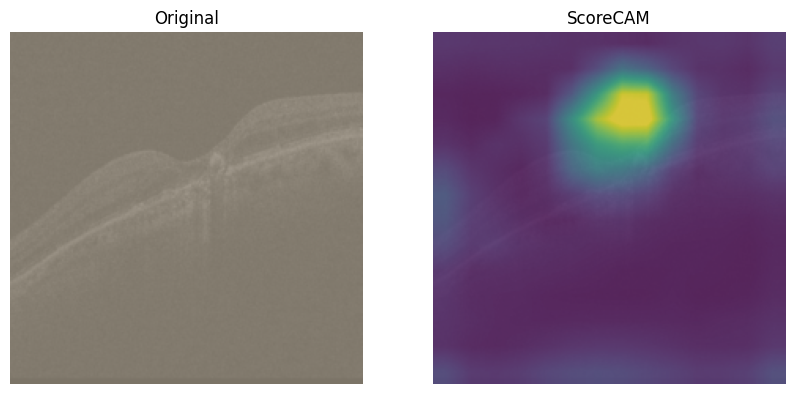

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0075.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0075.jpg


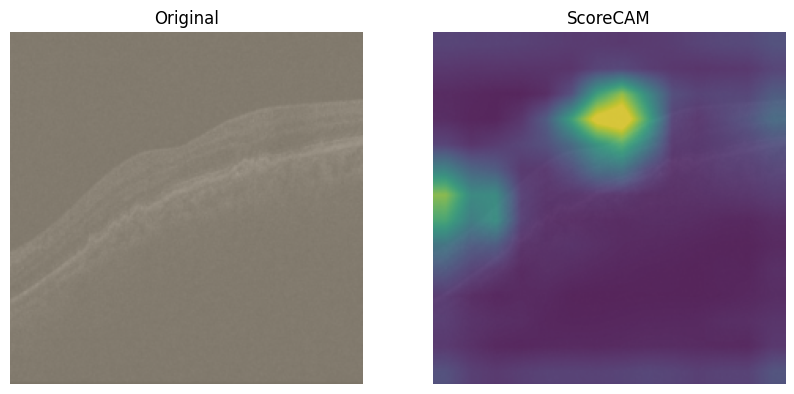

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0059.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0059.jpg


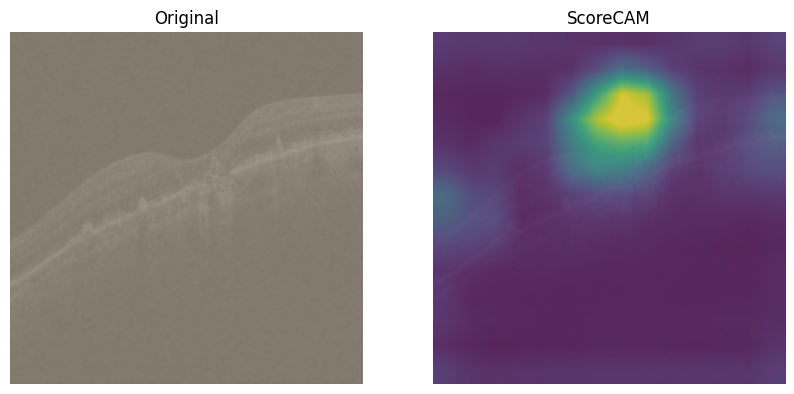

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0071.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0071.jpg


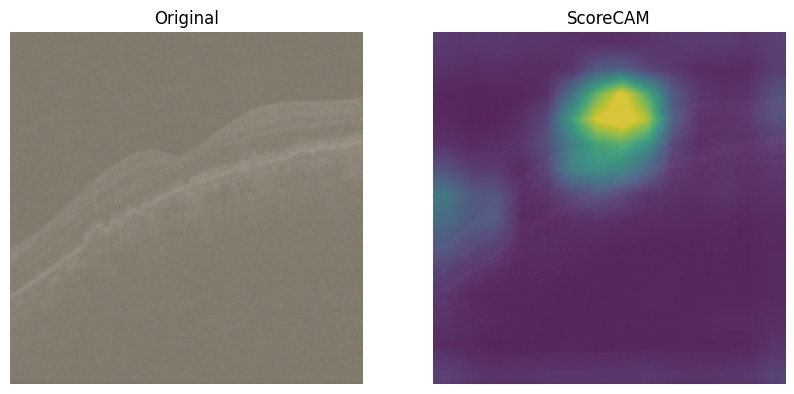

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0065.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0065.jpg


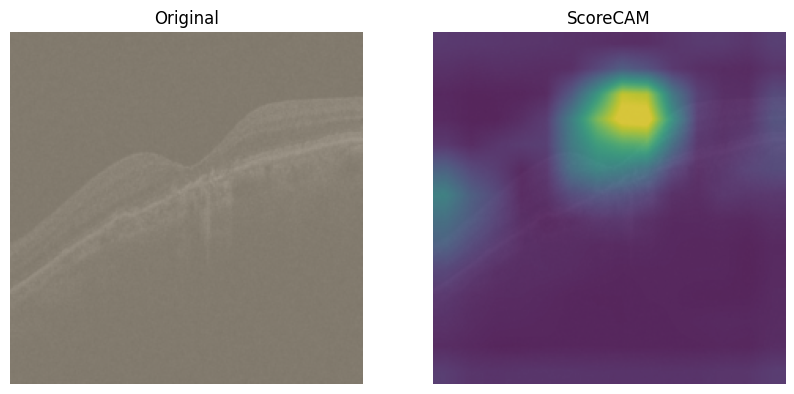

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0064.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0064.jpg


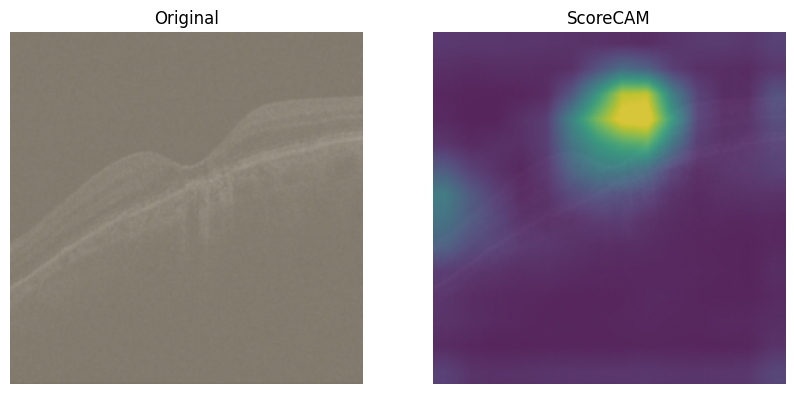

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0070.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0070.jpg


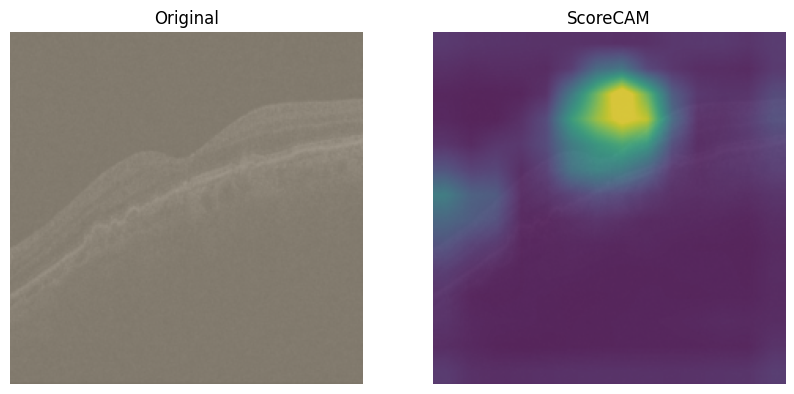

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0058.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0058.jpg


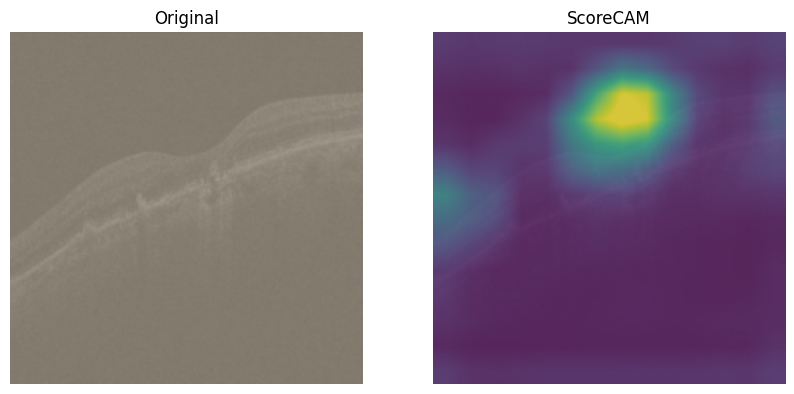

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0066.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0066.jpg


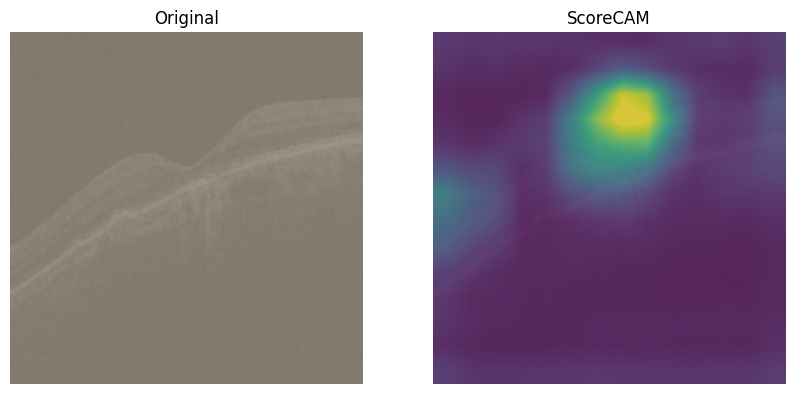

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0072.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0072.jpg


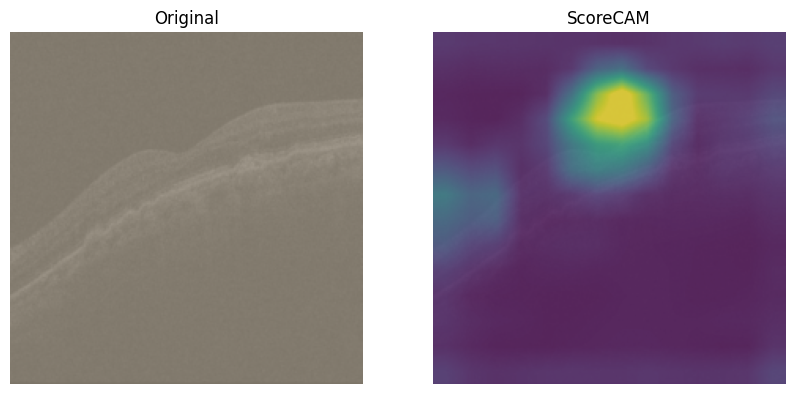

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0073.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0073.jpg


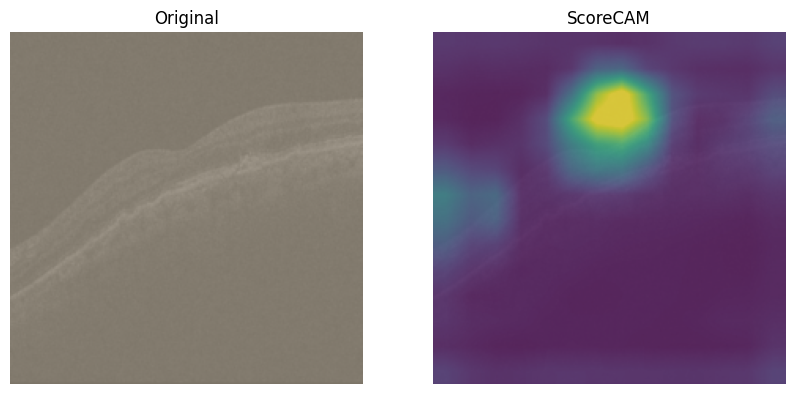

Image: 40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0067.jpg, Label: 1
Saved to score_cam/sample_Bscan_silces/cam_40002739_20211013_113000_L_OCT_512x1024x128_ORG_IMG_JPG_0067.jpg


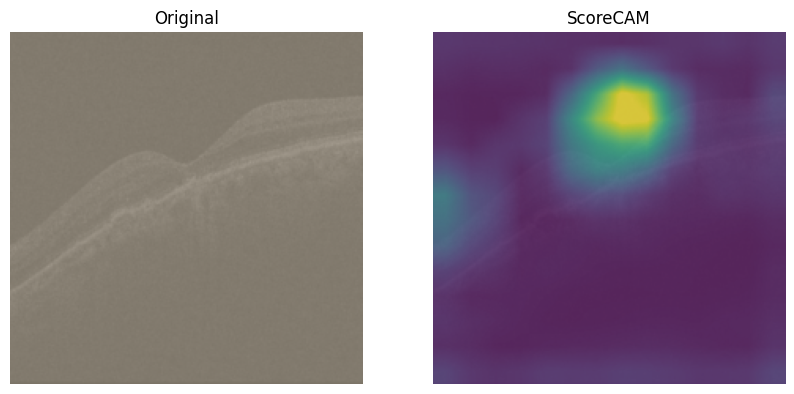

In [149]:
# sample_Bscan_slices
directory = "sample_Bscan_slices"
results_file = "class_1_predictions_sample_patient.txt"  
image_data = read_classification_results(results_file)
print("Total images: ",len(image_data))

# Show results 
for img_name, label in image_data:
    print(f"Image: {img_name}, Label: {label}")
    image_tensor = preprocess_image(img_name, directory).to(device)
    wrapped_model = ScoreCAM(model, target_layer)
    cam, idx = wrapped_model(image_tensor)
    basic_visualize(image_tensor.cpu(), cam.cpu(), 
                     save_path=os.path.join(f"score_cam/sample_Bscan_silces", f"cam_{img_name}"))